In [1]:
import xarray as xr
from xarray import DataArray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from py_ecosystem import compute_standardized_anomaly,pseudo_z_scores

#fonttype
# plt.rcParams['font.family'] = 'Arial'

### Open datasets

In [ ]:
# # chirps data
# chirps=[r"E:\_data\CHIRPS\chirps_2000_2015.nc",r"E:\_data\CHIRPS\chirps_2015_2023.nc"]
# #open chirps datasets and merge them
# chirps_list=[]
# for dataset in chirps:
#     chirps_ds=xr.open_dataset(dataset)
#     chirps_list.append(chirps_ds)
# chirps_ds=xr.merge(chirps_list)

# #rename the latitude and longitude variables
# chirps_ds=chirps_ds.rename({'latitude':'lat','longitude':'lon'})

# #Alternatively, open the NetCDF files as a single dataset.
# #chirps_ds=xr.open_mfdataset(chirps)

# #tamsat data
# # tamsat_ds=xr.open_dataset(r"E:\_data\TAMSAT\tamsatDaily_19830101-20231231_north_kenya.nc")
# #drop rfe variable and only rfe_filled is retained
# # tamsat_ds=tamsat_ds.drop('rfe')

# mswx data
mswx_ds=xr.open_dataset(r"E:\_data\MSWX_data\Daily\RF\MSWX_daily_RF_2000_2023.nc")

In [3]:
# #resample the data to monthly (ME is month end frequency)
# chirps_ds_mon=chirps_ds.resample(time='ME').sum()
# tamsat_ds_mon=tamsat_ds.resample(time='ME').sum()
mswx_ds_mon=mswx_ds.resample(time='ME').sum()

In [4]:
#gpp datasets
glass_gpp_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\GLASS_gpp_2000_2021.nc")
# glass_npp_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\GLASS_npp_2000_2021.nc")
pml_gpp_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\pml_v2_GPP_Ec.nc")
# modis_gpp_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\modis_gpp_2021_2023.nc")
modis_longterm_gpp_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\MODIS_8day_Gpp_2000_2023.nc")
# modis_psnet_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\MODIS_8day_PsNet_2000_2023.nc")

#resample to monthly
glass_gpp_mon=glass_gpp_ds.resample(time='ME').mean()
# glass_npp_mon=glass_npp_ds.resample(time='ME').mean()
pml_gpp_mon=pml_gpp_ds.resample(time='ME').mean()
modis_gpp_mon=modis_longterm_gpp_ds.resample(time='ME').mean()
# modis_psnet_mon=modis_psnet_ds.resample(time='ME').mean()

In [5]:
##groundwater water storage
gws_monthly=xr.open_dataset(r"D:\VUB\_data\nc_files\GLDAS_GWS_monthly.nc")

#LST
lst_ds_mon=xr.open_dataset(r"D:\VUB\_data\nc_files\modis_terra_LST_mon.nc")

In [8]:
#define no data values
modis_longterm_gpp_mon=modis_longterm_gpp_mon.where(modis_longterm_gpp_mon<32700)
# modis_psnet_mon=modis_psnet_mon.where(modis_psnet_mon<32700)

In [9]:
#ET and PET
modis_et_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\MODIS_ET_2000_2023.nc")
modis_pet_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\MODIS_PET_2000_2023.nc")

#resample to monthly
modis_et_mon=modis_et_ds.resample(time='ME').sum()
modis_pet_mon=modis_pet_ds.resample(time='ME').sum()

In [10]:
#evaporative stress index
modis_evap_fr=modis_et_mon['ET']/modis_pet_mon['PET']

mod_esi_mon=1-modis_evap_fr
#assign variable name to dataset
esi_mon=mod_esi_mon.to_dataset(name='ESI')

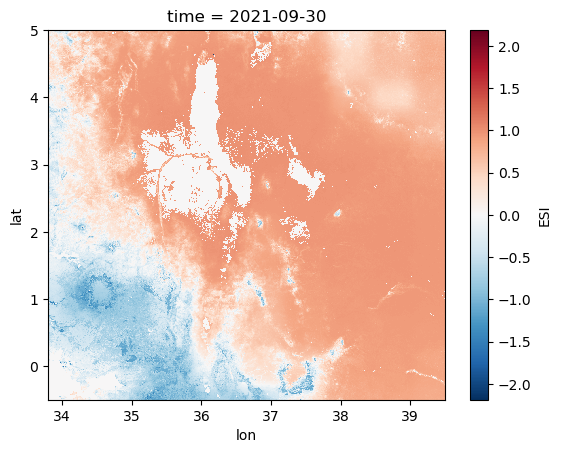

In [10]:
esi_mon['ESI'][260].plot();

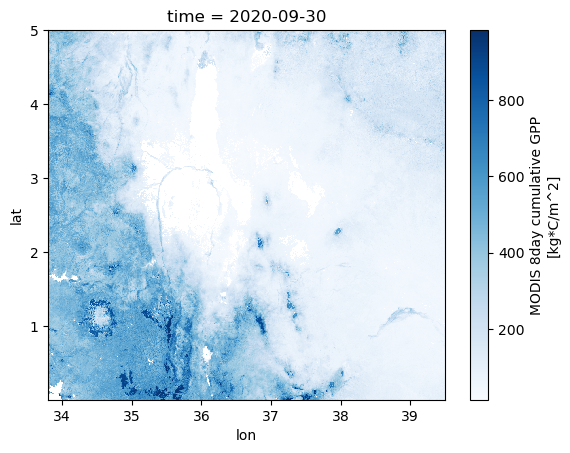

In [11]:
modis_longterm_gpp_mon['GPP'][248].plot(cmap='Blues');

In [15]:
## Soil moisture and TWS data
fldas_ds_mon=xr.open_dataset(r"D:\VUB\_data\nc_files\fldas_sm.nc")
gldas_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\gldas_SM_dataset.nc")
# esa_cci_ds=xr.open_dataset(r"D:\VUB\_data\nc_files\esa_cci_sm_2000_2022.nc")
gldas_tws = xr.open_dataset(r"D:\VUB\_data\nc_files\gldas_tws.nc")

#assign time to esa_cci_ds
# esa_cci_ds['time']=pd.date_range(start='2000-01-01',end='2022-12-31',freq='D')

#resample gldas and esa_cci to monthly
gldas_ds_mon=gldas_ds.resample(time='ME').mean()
gldas_tws_mon=gldas_tws.resample(time='ME').sum()

### Compute standardized monthly anomalies

In [29]:
ds_zscore_list=[]
for ds in [mswx_ds_mon,fldas_ds_mon['SoilMoi00_10cm'],pml_gpp_mon['GPP'],modis_gpp_mon, glass_gpp_mon]:
    z_anom = pseudo_z_scores(ds)
    ds_zscore_list.append(z_anom)

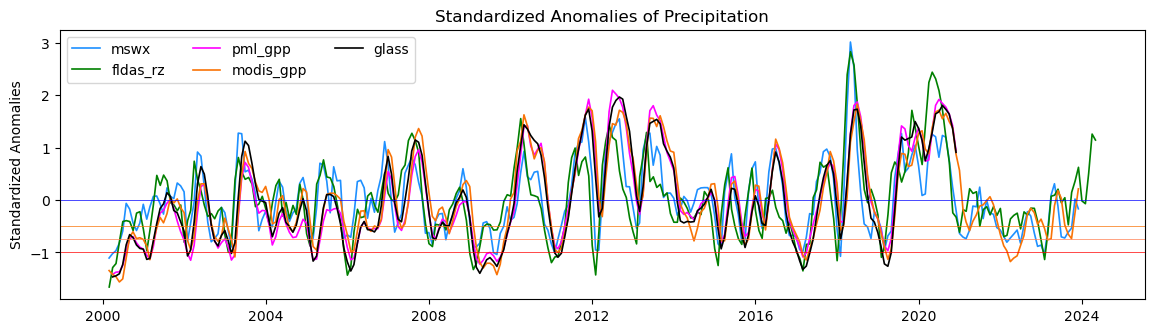

In [31]:
fig, ax = plt.subplots(figsize=(14, 3.5))
labels=['mswx','fldas_rz','pml_gpp', 'modis_gpp', 'glass']
colors=['dodgerblue','green','fuchsia','#F97306','k','#04D8B2']

for label,ds in zip(labels,ds_zscore_list):
    # Extract the standardized anomalies for a specific point
    anomaly = ds.sel(lat=slice(1.042,0.857), lon=slice(36.53,36.798)).mean(dim=['lat', 'lon'])
    anom_df=anomaly.to_dataframe()#.drop(columns=['lat','lon'])

    anom_df_smoothed = anom_df.rolling(window=3, center=True).mean()

    # Plot the standardized anomalies
    
    plt.plot(anom_df_smoothed['2000-01-01':], label=label, lw=1.2, color=colors[labels.index(label)])
ax.set_title('Standardized Anomalies of Precipitation')
ax.set_ylabel('Standardized Anomalies')
plt.axhline(0, color='b', linestyle='-', lw=0.5)
plt.axhline(-0.5, color='#F97306', linestyle='-', lw=0.5)
plt.axhline(-0.75, color='coral', linestyle='-', lw=0.5)
plt.axhline(-1.0, color='red', linestyle='-', lw=0.5)
ax.legend(ncols=3)  
plt.show()

In [17]:
pseudo_z_gg=[]
for ds in [mswx_ds_mon,fldas_ds_mon['SoilMoi10_40cm'],gleam_ssm_ds['SMs'], gldas_ds_mon['SoilMoist_RZ'], esa_cci_ds_mon['sm']]:
    z_anom = pseudo_z_scores(ds)
    pseudo_z_gg.append(z_anom)

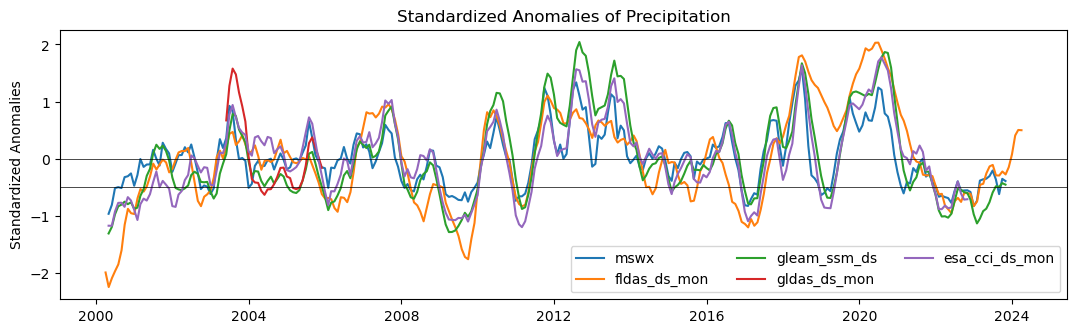

In [18]:
fig, ax = plt.subplots(figsize=(13, 3.5))
labels = ['mswx','fldas_ds_mon','gleam_ssm_ds',"gldas_ds_mon",'esa_cci_ds_mon']

for label,ds in zip(labels,pseudo_z_gg):
    # Extract the standardized anomalies for a specific point
    anomaly = ds.sel(lat=slice(1.042,0.857), lon=slice(36.53,36.798)).mean(dim=['lat', 'lon'])
    anom_df = anomaly.to_dataframe()

    anom_df_smoothed = anom_df.rolling(window=6, center=True).mean()

    # Plot the standardized anomalies
    
    plt.plot(anom_df_smoothed['2000-01-01':], label=label)
ax.set_title('Standardized Anomalies of Precipitation')
ax.set_ylabel('Standardized Anomalies')
plt.axhline(0, color='black', linestyle='-', lw=0.5)
plt.axhline(-0.5, color='black', linestyle='-', lw=0.5)
ax.legend(ncols=3)  
plt.show()

#### Monthly anomalies

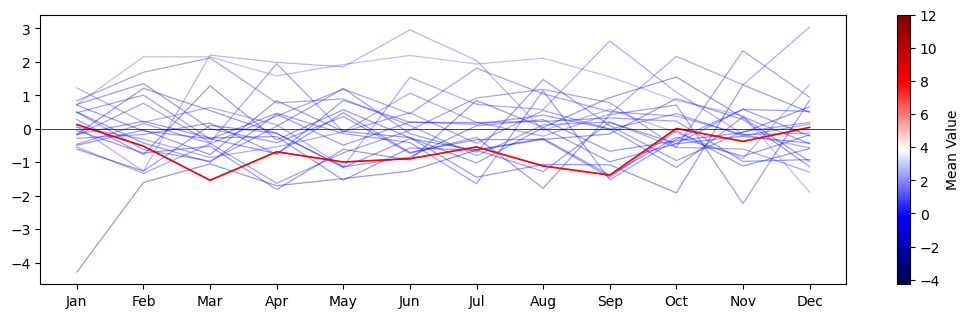

In [108]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(13, 3.5))

for ds in s_anoma[0:2]:
    monthly_avg = ds.groupby('time.month').mean(dim='time')
    
    # Group by year
    monthly_df = ds.sel(lat=slice(1.042, 0.857), lon=slice(36.53, 36.798)).mean(dim=['lat', 'lon']).to_dataframe()
    yearly_groups = monthly_df.pivot_table(index=monthly_df.index.month, columns=monthly_df.index.year, aggfunc='mean')
    
    # Replace month numbers with month names
    yearly_groups.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Normalize values to get a gradient effect
norm = plt.Normalize(vmin=yearly_groups.min().min(), vmax=yearly_groups.max().max())
cmap = matplotlib.colormaps['seismic']

for year in yearly_groups.iloc[:,0:22]:  # Exclude the last two columns
    values = yearly_groups[year]
    color = cmap(norm(values.mean()))  # Color based on the average value of the line
    plt.plot(values, color=color, alpha=0.4, lw=0.9)

#Plot specific years in red and blue
plt.plot(yearly_groups.iloc[:, 9:10].droplevel(level=0, axis=1), c='r', alpha=1, lw=1.2)


plt.axhline(0, color='black', linestyle='-', lw=0.5)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Mean Value')
plt.show()

In [104]:
#check level 0 headers
yearly_groups.columns.get_level_values(0)

Index(['SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm',
       'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm',
       'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm',
       'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm',
       'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm',
       'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm', 'SoilMoi00_10cm',
       'SoilMoi00_10cm', 'month', 'month', 'month', 'month', 'month', 'month',
       'month', 'month', 'month', 'month', 'month', 'month', 'month', 'month',
       'month', 'month', 'month', 'month', 'month', 'month', 'month', 'month',
       'month', 'month', 'month'],
      dtype='object')

In [ ]:
s_anoma=[]
for ds in [modis_longterm_gpp_mon,lst_ds_mon,fldas_ds_mon['SoilMoi00_10cm'],fldas_ds_mon['SoilMoi10_40cm'],gldas_tws_mon, gws_monthly]:
    standardized_anom=compute_standardized_anomaly(ds)
    s_anoma.append(standardized_anom)

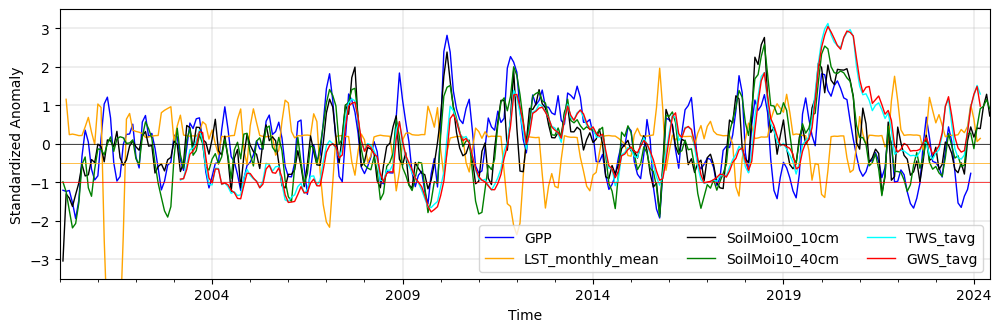

In [119]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 3.5))

# Define colors for the plot lines
colors = ['blue','orange','k','green','cyan', 'red','k','m']

# Loop through each anomaly dataset and plot
for color, anom in zip(colors, s_anoma):
    
    # Select the nearest latitude and longitude for plotting
    anom_stdzd = anom.sel(lat= 1, lon= 36.5, method='nearest')
    
    # Convert to DataFrame and drop unwanted columns
    anom_stdzd_df = anom_stdzd.to_dataframe().drop(columns=['lat','lon','month'])

    #apply smoothing using a rolling window
    window_size = 2
    anom_stdzd_df = anom_stdzd_df.rolling(window=window_size,center=True).mean()
    
    # Plot the data with a color and line width
    anom_stdzd_df.loc['2000-01-01':].plot(ax=ax, color=color, lw=1.0)

# Plot a horizontal line at y=0
plt.axhline(y=0, color='black', lw=0.5)
plt.axhline(y=-1, color='r', lw=0.5)
plt.axhline(y=-0.5, color='orange', lw=0.5)
plt.ylim(-3.5, 3.5)
plt.grid(True, lw=0.3, axis='both')
# Optional: Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Standardized Anomaly')
plt.legend(ncols=3)

# Show the plot
plt.show()

#### Aridity

In [22]:
#calculate aridity index as the ratio of annual precipitation to potential evapotranspiration

# annual_precip=chirps_ds_mon.groupby('time.year').sum()
annual_mswx=mswx_ds_mon.groupby('time.year').sum()
annual_pet=modis_pet_mon.groupby('time.year').sum()

# aridity_index=annual_precip/annual_pet

In [23]:
# Example: Soil moisture data for 100 time steps (replace with actual data)
soil_moisture_data = np.random.gamma(shape=2, scale=1.5, size=100)

# Step 1: Fit the gamma distribution to the soil moisture data
shape, loc, scale = stats.gamma.fit(soil_moisture_data)

# Step 2: Transform the soil moisture values to a cumulative probability distribution (CDF)
cdf_values = stats.gamma.cdf(soil_moisture_data, shape, loc=loc, scale=scale)

# Step 3: Convert the CDF values to a standard normal distribution to get the standardized soil moisture index (SSI)
ssi_values = stats.norm.ppf(cdf_values)

# Step 4: Calculate standardized anomalies (SXI) using mean and standard deviation
mean_sm = np.mean(soil_moisture_data)
std_sm = np.std(soil_moisture_data)
sxi_values = (soil_moisture_data - mean_sm) / std_sm

# Output the first few SSI and SXI values
ssi_values[:10], sxi_values[:10]


<xarray.DataArray (lat: 0, lon: 0)>
array([], shape=(0, 0), dtype=float32)
Coordinates:
  * lon      (lon) float64 
  * lat      (lat) float64 
    year     int64 2000

### Drought indices

In [ ]:
import numpy as np
from scipy.stats import gamma, norm

# Step 1: Gather precipitation data (e.g., monthly data)
precipitation_data = np.array([23, 45, 67, 89, 12, 34, 56, 78, 90, 11, 22, 33])  # Example data

# Step 2: Choose a time scale (e.g., 3-month SPI)
time_scale = 3
if time_scale > 1:
    precipitation_data = np.convolve(precipitation_data, np.ones(time_scale), 'valid') / time_scale

# Step 4: Fit a Gamma distribution to the data
shape, loc, scale = gamma.fit(precipitation_data, floc=0)

# Step 5: Calculate the cumulative probability of the observed data
cumulative_probabilities = gamma.cdf(precipitation_data, shape, loc=loc, scale=scale)

# Step 6: Convert the cumulative probabilities to the standard normal distribution (SPI)
spi_values = norm.ppf(cumulative_probabilities)

# Print the SPI values
print("SPI values:", spi_values)

In [4]:
gldas_ds

NameError: name 'gldas_ds' is not defined